In [185]:
#@title Imports.  {vertical-output: true}


import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.distributions.categorical import Categorical

from utils import *

torch.autograd.set_detect_anomaly(True)

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Policy Network

Defining a neural network structure which will be used as policies of the agents

In [86]:
# Policy network class

class policy_net(nn.Module):
    
    def __init__(self,input_dim,output_dim,hidden_dim=16):
        super(policy_net,self).__init__()
        self.fc = nn.Sequential(nn.Linear(input_dim,hidden_dim),nn.ReLU(),nn.Linear(hidden_dim,output_dim),nn.LogSoftmax(dim=1))
        
    def forward(self,state,get_entropy=False):
        logits = self.fc(state)
        dist = Categorical(logits=logits)
        action = dist.sample()
        log_prob = dist.log_prob(action)
        if get_entropy:
            entropy = dist.entropy().view(-1,1)
            return action,log_prob,entropy
        else:
            return action,log_prob


        
        
        
class policy_deepnet(nn.Module):
    
    def __init__(self,input_dim,output_dim,hidden_dim=16):
        super(policy_deepnet,self).__init__()
        self.fc = nn.Sequential(nn.Linear(input_dim,hidden_dim),nn.ReLU(),nn.Linear(hidden_dim,hidden_dim),nn.ReLU(),nn.Linear(hidden_dim,output_dim),nn.LogSoftmax(dim=1))
        
    def forward(self,state,get_entropy=False):
        logits = self.fc(state)
        dist = Categorical(logits=logits)
        action = dist.sample()
        log_prob = dist.log_prob(action)
        if get_entropy:
            entropy = dist.entropy().view(-1,1)
            return action,log_prob,entropy
        else:
            return action,log_prob

# Training with zero enforced in state 0


In [94]:
# Training function
from IPython.display import clear_output

def train_zero_enforced(policy_0,policy_1,p0,p1,num_epochs,rollout_size,horizon,gamma,lr,
                        is_different_reward=False,with_entropy=False,entropy_coeff=0.1,seed=100,print_interval=50):
    """
    policy_0,1 - policy network of the two agents
    p0,p1 - packet arrival rates for agent0 and agent1
    num_epochs - No of training epochs
    rollout_size - No of rollouts of the MDP
    horizon - Time horizon of the MDP
    gamma - discount factor
    """
    
    print('Training begins')
    optimizer = torch.optim.Adam(list(policy_0.parameters())+ list(policy_1.parameters()),lr=lr)
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    rewards = []
    successes = []
    
    for i in range(num_epochs):
        #print('Starting epoch {}'.format(i))
        
        eps_success = []
        eps_reward = []
        eps_log_p0 = []
        eps_log_p1 = []
        eps_entropy_0 = []
        eps_entropy_1 = []
        total_reward = torch.zeros(rollout_size,requires_grad=False)
        total_success = torch.zeros(rollout_size,requires_grad=False)
        
        ## Generating rollouts with the current policy
        state0,state1,belief = reset(rollout_size,p0,p1)
        
        
        for t in range(horizon):
            
            # computing the prescription and actions based on current state and belief
            if with_entropy:
                prescription_0,log_p0_tilde,entropy_0 = policy_0(belief,get_entropy=True)
                prescription_1,log_p1_tilde,entropy_1 = policy_1(belief,get_entropy=True)
            else:
                prescription_0,log_p0_tilde = policy_0(belief,get_entropy=False)
                prescription_1,log_p1_tilde = policy_1(belief,get_entropy=False)
            
            # Computing the action and corresponding action log probability for each agent based on its state
            u0 = state0*prescription_0
            u1 = state1*prescription_1
            
            log_p0 = state0*log_p0_tilde
            log_p1 = state1*log_p1_tilde
            
            
            success = compute_reward(u0,u1)
            if is_different_reward:
                #reward = diverse_reward(state0,state1,u0,u1)
                reward = penalize_state_reward(state0,state1,u0,u1)
            else:
                reward = success
            
            """
            print('Time:',t)
            print('Prescription 0:', prescription_0)
            print('state0',state0)
            print('u0 ', u0)
            
            print('Prescription 1:', prescription_1)
            print('state1',state1)
            print('u1',u1)
            print('reward',reward)
            
            print('Entropy of agent 0 is {}'.format(entropy_0))
            print('Entropy of agent 1 is {}'.format(entropy_1))
            """
            
            ## Recording reward and log_prob
            eps_success.append(success)
            eps_reward.append(reward)
            eps_log_p0.append(log_p0.unsqueeze(1))
            eps_log_p1.append(log_p1.unsqueeze(1))
            
            if with_entropy:
                eps_entropy_0.append(entropy_0)
                eps_entropy_1.append(entropy_1)
            
            total_reward += reward
            total_success += success
            
            ## finding the next state and belief
            next_state0,next_state1 = transition(state0,state1,u0,u1,p0,p1)
            next_belief = belief_update(belief,prescription_0,prescription_1,u0,u1,p0,p1)
                    
            state0 = next_state0
            state1 = next_state1
            belief = next_belief
            
            
        
        ## compute the returns

        returns_batch = compute_episode_returns(eps_reward,rollout_size,horizon,gamma)
       
        
        ### Updating the policy
        
        eps_log_prob_0 = torch.cat((eps_log_p0[:]),dim=1)
        eps_log_prob_1 = torch.cat((eps_log_p1[:]),dim=1)
        
        if with_entropy: 
            eps_entropy_0 = torch.cat((eps_entropy_0[:]),dim=1)
            eps_entropy_1 = torch.cat((eps_entropy_1[:]),dim=1)
            entropy_loss = -entropy_coeff*(torch.mean(eps_entropy_0)+torch.mean(eps_entropy_1))
        
        policy_loss = -torch.mean(returns_batch*eps_log_prob_0) - torch.mean(returns_batch*eps_log_prob_1)
        
        
        if with_entropy:
            loss = policy_loss + entropy_loss
        else:
            loss = policy_loss
        
        optimizer.zero_grad()
        loss.backward(retain_graph=False)
        optimizer.step()
            
        ## Logging the average reward for this epoch
        
        rewards.append(torch.mean(total_reward).item())
        successes.append(torch.mean(total_success).item())
        
        ## Printing the current mean reward and success
        if i % print_interval == 0:
            print('Mean reward in epoch {} is {}'.format(i,torch.mean(total_reward).item()))
            if is_different_reward:
                print('Mean success in epoch {} is {}'.format(i,torch.mean(total_success).item()))
        
        
    print('Mean reward at the end of training {}'.format(torch.mean(total_reward).item()))
    if is_different_reward:
        print('Mean success at the end of training {}'.format(torch.mean(total_success).item()))
    
    #clear_output()
    return successes


In [80]:
def test_policies(policy_0,policy_1):
    
    state0 = torch.tensor([1.0,0.0]).reshape(1,2)
    state1 = torch.tensor([0.0,1.0]).reshape(1,2)

    count0_0 = 0
    count1_0 = 0
    count0_1 = 0
    count1_1 = 0

    for i in range(100):
        u0_0,_ = policy_0(state0)
        u1_0,_ = policy_1(state0)
    
        count0_0 += u0_0.item()
        count1_0 += u1_0.item()

        u0_1,_ = policy_0(state1)
        u1_1,_ = policy_1(state1)
    
        count0_1 += u0_1.item()
        count1_1 += u1_1.item()


    print('No of times transmit is prescribed to agent 0 when belief=[1,0] is {}/100'.format(count0_0))
    print('No of times transmit is prescribed to agent 1 when belief=[1,0] is {}/100'.format(count1_0))
    print('No of times transmit is prescribed to agent 0 when belief=[0,1] is {}/100'.format(count0_1))
    print('No of times transmit is prescribed to agent 1 when belief=[0,1] is {}/100'.format(count1_1))
    

In [81]:
def instantiate_policy(input_dim=2,output_dim=2,hidden_dim=8):
    policy_0 = policy_net(input_dim=input_dim,output_dim=output_dim,hidden_dim=hidden_dim)
    policy_1 = policy_net(input_dim=input_dim,output_dim=output_dim,hidden_dim=hidden_dim)
    
    return policy_0,policy_1


### Training without entropy loss and reward shaping

In [82]:
n_seeds = 3
successes = []

for i in range(n_seeds):
    policy_0,policy_1 = instantiate_policy()
    s = train_zero_enforced(policy_0,policy_1,p0=0.7,p1=0.6,num_epochs=500,rollout_size=300,horizon=20,gamma=1,
                             lr=5e-3,is_different_reward=False,with_entropy=False,entropy_coeff=0.1,seed=i)
    successes.append(s)
    test_policies(policy_0,policy_1)
    
print('Training Complete!')

Training begins
Mean reward in epoch 0 is 10.09666633605957
Mean reward in epoch 50 is 10.670000076293945
Mean reward in epoch 100 is 13.196666717529297
Mean reward in epoch 150 is 13.973333358764648
Mean reward in epoch 200 is 13.9399995803833
Mean reward in epoch 250 is 13.976666450500488
Mean reward in epoch 300 is 13.84333324432373
Mean reward in epoch 350 is 14.00333309173584
Mean reward in epoch 400 is 13.90999984741211
Mean reward in epoch 450 is 14.046667098999023
Mean reward at the end of training 13.956666946411133
No of times transmit is prescribed to agent 0 when belief=[1,0] is 100/100
No of times transmit is prescribed to agent 1 when belief=[1,0] is 0/100
No of times transmit is prescribed to agent 0 when belief=[0,1] is 100/100
No of times transmit is prescribed to agent 1 when belief=[0,1] is 2/100
Training begins
Mean reward in epoch 0 is 9.880000114440918
Mean reward in epoch 50 is 10.716666221618652
Mean reward in epoch 100 is 11.783333778381348
Mean reward in epoch

/Users/mukul/anaconda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


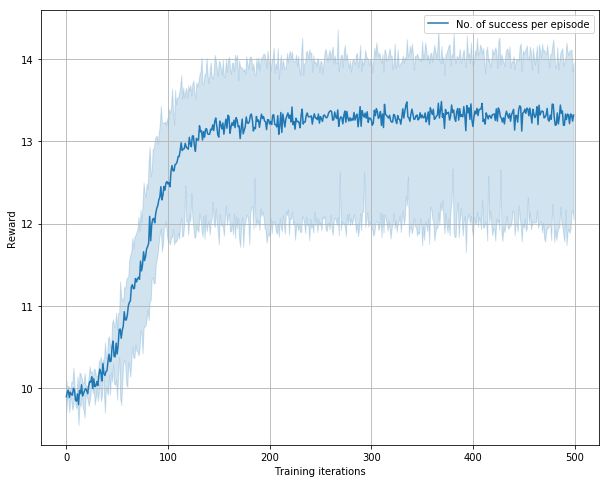

In [83]:
plot_reward(successes)

### Adding another layer to the policy network


In [84]:
def instantiate_deeppolicy(input_dim=2,output_dim=2,hidden_dim=8):
    policy_0 = policy_deepnet(input_dim=input_dim,output_dim=output_dim,hidden_dim=hidden_dim)
    policy_1 = policy_deepnet(input_dim=input_dim,output_dim=output_dim,hidden_dim=hidden_dim)
    
    return policy_0,policy_1

In [87]:
n_seeds = 3
successes = []

for i in range(n_seeds):
    policy_0,policy_1 = instantiate_deeppolicy()
    s = train_zero_enforced(policy_0,policy_1,p0=0.7,p1=0.6,num_epochs=500,rollout_size=300,horizon=20,gamma=1,
                             lr=5e-3,is_different_reward=False,with_entropy=False,entropy_coeff=0.1,seed=i)
    successes.append(s)
    test_policies(policy_0,policy_1)
    
print('Training Complete!')

Training begins
Mean reward in epoch 0 is 9.583333015441895
Mean reward in epoch 50 is 12.713333129882812
Mean reward in epoch 100 is 13.693333625793457
Mean reward in epoch 150 is 14.130000114440918
Mean reward in epoch 200 is 13.963333129882812
Mean reward in epoch 250 is 14.050000190734863
Mean reward in epoch 300 is 13.880000114440918
Mean reward in epoch 350 is 14.046667098999023
Mean reward in epoch 400 is 13.91333293914795
Mean reward in epoch 450 is 14.056666374206543
Mean reward at the end of training 14.010000228881836
No of times transmit is prescribed to agent 0 when belief=[1,0] is 100/100
No of times transmit is prescribed to agent 1 when belief=[1,0] is 0/100
No of times transmit is prescribed to agent 0 when belief=[0,1] is 100/100
No of times transmit is prescribed to agent 1 when belief=[0,1] is 0/100
Training begins
Mean reward in epoch 0 is 9.893333435058594
Mean reward in epoch 50 is 10.976666450500488
Mean reward in epoch 100 is 11.863333702087402
Mean reward in e

### Training with entropy loss

In [ ]:
n_seeds = 3
successes_w_entropy = []

for i in range(n_seeds):
    policy_0,policy_1 = instantiate_policy()
    s = train_zero_enforced(policy_0,policy_1,p0=0.7,p1=0.6,num_epochs=2000,rollout_size=300,horizon=20,gamma=0.95,
                             lr=5e-3,is_different_reward=False,with_entropy=True,entropy_coeff=0.2,seed=i,print_interval=100)
    successes_w_entropy.append(s)
    test_policies(policy_0,policy_1)
    
print('Training Complete!')

Training begins
Mean reward in epoch 0 is 10.123332977294922
Mean reward in epoch 100 is 10.103333473205566
Mean reward in epoch 200 is 10.99666690826416
Mean reward in epoch 300 is 11.216666221618652
Mean reward in epoch 400 is 11.550000190734863
Mean reward in epoch 500 is 12.050000190734863
Mean reward in epoch 600 is 13.0
Mean reward in epoch 700 is 13.5
Mean reward in epoch 800 is 13.979999542236328
Mean reward in epoch 900 is 14.34000015258789
Mean reward in epoch 1000 is 14.466666221618652
Mean reward in epoch 1100 is 14.706666946411133
Mean reward in epoch 1200 is 15.083333015441895
Mean reward in epoch 1300 is 15.216666221618652
Mean reward in epoch 1400 is 14.976666450500488
Mean reward in epoch 1500 is 14.979999542236328
Mean reward in epoch 1600 is 15.529999732971191
Mean reward in epoch 1700 is 15.609999656677246
Mean reward in epoch 1800 is 15.433333396911621
Mean reward in epoch 1900 is 15.296667098999023
Mean reward at the end of training 15.673333168029785
No of times 

/Users/mukul/anaconda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


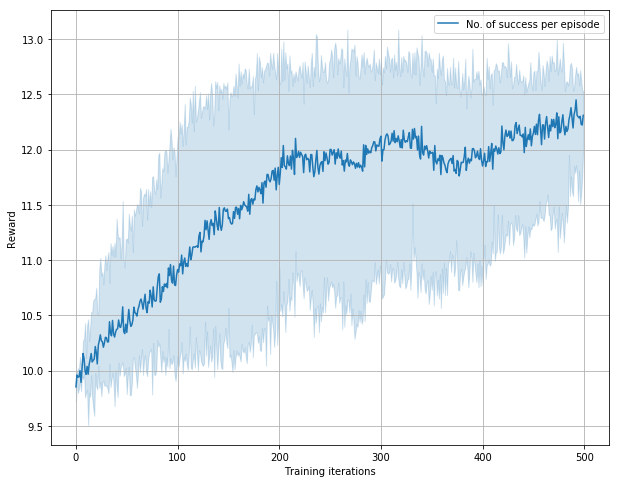

In [89]:
plot_reward(successes_w_entropy)

In [36]:
test_policies(policy_0,policy_1)

No of times transmit is prescribed to agent 0 when belief=[1,0] is 83/100
No of times transmit is prescribed to agent 1 when belief=[1,0] is 28/100
No of times transmit is prescribed to agent 0 when belief=[0,1] is 61/100
No of times transmit is prescribed to agent 1 when belief=[0,1] is 62/100


### Training with reward shaping

Here we train with a different reward function. This is done by setting the flag is_different_reward=True in train_zero_enforced function. The new reward comes from the diverse_reward function in the utils file.

In [92]:
n_seeds = 3
successes_diverse_reward = []

for i in range(n_seeds):
    print('Iteration no {}'.format(i))
    policy_0,policy_1 = instantiate_policy()
    s = train_zero_enforced(policy_0,policy_1,p0=0.7,p1=0.6,num_epochs=600,rollout_size=300,horizon=20,gamma=1,
                             lr=5e-3,is_different_reward=True,with_entropy=False,entropy_coeff=0.13,seed=i,print_interval=100)
    successes_diverse_reward.append(s)
    test_policies(policy_0,policy_1)
    
print('Training Complete!')

Iteration no 0
Training begins
Mean reward in epoch 0 is 3.8333332538604736
Mean success in epoch 0 is 9.539999961853027
Mean reward in epoch 100 is 6.62666654586792
Mean success in epoch 100 is 12.556666374206543
Mean reward in epoch 200 is 8.170000076293945
Mean success in epoch 200 is 13.956666946411133
Mean reward in epoch 300 is 7.943333148956299
Mean success in epoch 300 is 13.84666633605957
Mean reward in epoch 400 is 8.010000228881836
Mean success in epoch 400 is 13.90666675567627
Mean reward in epoch 500 is 8.126667022705078
Mean success in epoch 500 is 13.966666221618652
Mean reward at the end of training 8.106666564941406
Mean success at the end of training 13.960000038146973
No of times transmit is prescribed to agent 0 when belief=[1,0] is 100/100
No of times transmit is prescribed to agent 1 when belief=[1,0] is 0/100
No of times transmit is prescribed to agent 0 when belief=[0,1] is 100/100
No of times transmit is prescribed to agent 1 when belief=[0,1] is 0/100
Iteratio

/Users/mukul/anaconda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


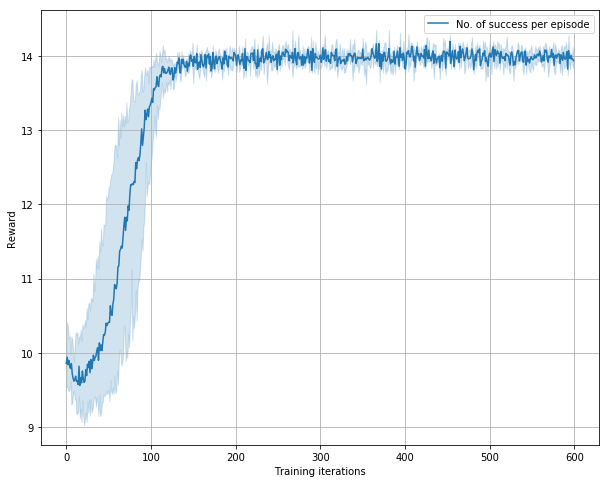

In [93]:
plot_reward(successes_diverse_reward)

### Penalizing state

We try to penalize the state 1 in order to avoid the policy of one agent to remain always silent

In [95]:
n_seeds = 3
successes_diverse_reward = []

for i in range(n_seeds):
    print('Iteration no {}'.format(i))
    policy_0,policy_1 = instantiate_policy()
    s = train_zero_enforced(policy_0,policy_1,p0=0.7,p1=0.6,num_epochs=600,rollout_size=300,horizon=20,gamma=1,
                             lr=5e-3,is_different_reward=True,with_entropy=False,entropy_coeff=0.13,seed=i,print_interval=100)
    successes_diverse_reward.append(s)
    test_policies(policy_0,policy_1)
    
print('Training Complete!')

Iteration no 0
Training begins
Mean reward in epoch 0 is 0.5066666603088379
Mean success in epoch 0 is 10.123332977294922
Mean reward in epoch 100 is 0.6033333539962769
Mean success in epoch 100 is 9.323333740234375
Mean reward in epoch 200 is 0.6466666460037231
Mean success in epoch 200 is 9.899999618530273
Mean reward in epoch 300 is 0.6566666960716248
Mean success in epoch 300 is 10.460000038146973
Mean reward in epoch 400 is 0.9233333468437195
Mean success in epoch 400 is 11.779999732971191
Mean reward in epoch 500 is 0.8500000238418579
Mean success in epoch 500 is 12.146666526794434
Mean reward at the end of training 0.8700000047683716
Mean success at the end of training 12.506667137145996
No of times transmit is prescribed to agent 0 when belief=[1,0] is 98/100
No of times transmit is prescribed to agent 1 when belief=[1,0] is 77/100
No of times transmit is prescribed to agent 0 when belief=[0,1] is 0/100
No of times transmit is prescribed to agent 1 when belief=[0,1] is 100/100


## Centralized Training

In this section we will implement the centralized policy gradient where each agent has access to both the states and then decide their actions

In [190]:
class centralized_policy_net(nn.Module):
    
    def __init__(self,input_dim,output_dim,hidden_dim=16):
        super(centralized_policy_net,self).__init__()
        self.fc = nn.Sequential(nn.Linear(input_dim,hidden_dim),nn.ReLU(),nn.Linear(hidden_dim,output_dim),nn.LogSoftmax(dim=1))
        
    def forward(self,state,get_entropy=False):
        logits = self.fc(state)
        dist = Categorical(logits=logits)
        action = dist.sample()
        log_prob = dist.log_prob(action)
        if get_entropy:
            entropy = dist.entropy().view(-1,1)
            return action,log_prob,entropy
        else:
            return action,log_prob


In [215]:





def train_centralized(policy,p0,p1,num_epochs,rollout_size,horizon,gamma,lr,
                        is_different_reward=False,with_entropy=False,entropy_coeff=0.1,seed=100,print_interval=50):
    """
    policy_0,1 - policy network of the two agents
    p0,p1 - packet arrival rates for agent0 and agent1
    num_epochs - No of training epochs
    rollout_size - No of rollouts of the MDP
    horizon - Time horizon of the MDP
    gamma - discount factor
    """
    
    print('Training begins')
    optimizer = torch.optim.Adam(policy.parameters(),lr=lr)
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    rewards = []
    successes = []
    
    for i in range(num_epochs):
        #print('Starting epoch {}'.format(i))
        
        eps_success = []
        eps_reward = []
        eps_log_p = []
        eps_entropy = []
        total_reward = torch.zeros(rollout_size,requires_grad=False)
        total_success = torch.zeros(rollout_size,requires_grad=False)
        
        ## Generating rollouts with the current policy
        state0,state1,_ = reset(rollout_size,p0,p1)
        
        
        for t in range(horizon):
            
            # computing the prescription and actions based on current state and belief
            
            state = torch.cat((state0.view(-1,1),state1.view(-1,1)),dim=1).type(torch.float)
            
            if with_entropy:
                u,log_p,entropy = policy(state,get_entropy=True)
            else:
                u,log_p = policy(state,get_entropy=False)
            
            # Computing the action and corresponding action log probability for each agent based on its state
            u0 = state0*u//2
            u1 = state1*u%2
            
            success = compute_reward(u0,u1)
            if is_different_reward:
                #reward = diverse_reward(state0,state1,u0,u1)
                reward = penalize_state_reward(state0,state1,u0,u1)
            else:
                reward = success
            
            """
            print('Time:',t)
            print('Prescription 0:', prescription_0)
            print('state0',state0)
            print('u0 ', u0)
            
            print('Prescription 1:', prescription_1)
            print('state1',state1)
            print('u1',u1)
            print('reward',reward)
            
            print('Entropy of agent 0 is {}'.format(entropy_0))
            print('Entropy of agent 1 is {}'.format(entropy_1))
            """
            
            ## Recording reward and log_prob
            eps_success.append(success)
            eps_reward.append(reward)
            eps_log_p.append(log_p.unsqueeze(1))
            
            if with_entropy:
                eps_entropy.append(entropy)
            
            total_reward += reward
            total_success += success
            
            ## finding the next state and belief
            next_state0,next_state1 = transition(state0,state1,u0,u1,p0,p1)
            #next_belief = belief_update(belief,prescription_0,prescription_1,u0,u1,p0,p1)
                    
            state0 = next_state0
            state1 = next_state1
            #belief = next_belief
            
            
        
        ## compute the returns

        returns_batch = compute_episode_returns(eps_reward,rollout_size,horizon,gamma)
       
        
        ### Updating the policy
        
        eps_log_prob = torch.cat((eps_log_p[:]),dim=1)
        
        if with_entropy: 
            eps_entropy = torch.cat((eps_entropy[:]),dim=1)
            entropy_loss = -entropy_coeff*torch.mean(eps_entropy)
        
        policy_loss = -torch.mean(returns_batch*eps_log_prob)
        
        
        if with_entropy:
            loss = policy_loss + entropy_loss
        else:
            loss = policy_loss
        
        optimizer.zero_grad()
        loss.backward(retain_graph=False)
        optimizer.step()
            
        ## Logging the average reward for this epoch
        
        rewards.append(torch.mean(total_reward).item())
        successes.append(torch.mean(total_success).item())
        
        ## Printing the current mean reward and success
        if i % print_interval == 0:
            print('Mean reward in epoch {} is {}'.format(i,torch.mean(total_reward).item()))
            if is_different_reward:
                print('Mean success in epoch {} is {}'.format(i,torch.mean(total_success).item()))
        
        
    print('Mean reward at the end of training {}'.format(torch.mean(total_reward).item()))
    if is_different_reward:
        print('Mean success at the end of training {}'.format(torch.mean(total_success).item()))
    
    #clear_output()
    return successes


In [210]:
def test_centralized_policy(policy,n_sim=100):
    
    
    count0 = np.zeros(4)
    count1 = np.zeros(4)
    
    for i in range(4):
        state = torch.tensor([i//2,i%2]).view(1,2).type(torch.float)
        for _ in range(n_sim):
            u,_ = policy(state)
            
            u0 = u//2
            u1 = u%2
    
            count0[i] += u0.item()
            count1[i] += u1.item()


    for i in range(4):
        print('No of times agent 0 transmits when state is ({},{}) is {}/{}'.format(i//2,i%2,count0[i],n_sim))
        print('No of times agent 1 transmits when state is ({},{}) is {}/{}'.format(i//2,i%2,count1[i],n_sim))

In [216]:
n_seeds = 3
centralized_successes = []

for i in range(n_seeds):
    print('Iteration no {}'.format(i))
    policy = centralized_policy_net(input_dim=2,output_dim=4)
    s = train_centralized(policy,p0=0.7,p1=0.6,num_epochs=600,rollout_size=300,horizon=20,gamma=1,
                             lr=5e-3,is_different_reward=False,with_entropy=False,entropy_coeff=0.13,seed=i,print_interval=100)
    centralized_successes.append(s)
    test_centralized_policy(policy)
    
print('Training Complete!')



Iteration no 0
Training begins
Mean reward in epoch 0 is 10.803333282470703
Mean reward in epoch 100 is 16.809999465942383
Mean reward in epoch 200 is 18.3266658782959
Mean reward in epoch 300 is 18.690000534057617
Mean reward in epoch 400 is 18.683332443237305
Mean reward in epoch 500 is 18.763334274291992
Mean reward at the end of training 18.81999969482422
No of times agent 0 transmits when state is (0,0) is 54.0/100
No of times agent 1 transmits when state is (0,0) is 48.0/100
No of times agent 0 transmits when state is (0,1) is 1.0/100
No of times agent 1 transmits when state is (0,1) is 99.0/100
No of times agent 0 transmits when state is (1,0) is 100.0/100
No of times agent 1 transmits when state is (1,0) is 0.0/100
No of times agent 0 transmits when state is (1,1) is 92.0/100
No of times agent 1 transmits when state is (1,1) is 8.0/100
Iteration no 1
Training begins
Mean reward in epoch 0 is 12.316666603088379
Mean reward in epoch 100 is 17.573333740234375
Mean reward in epoch 

/Users/mukul/anaconda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


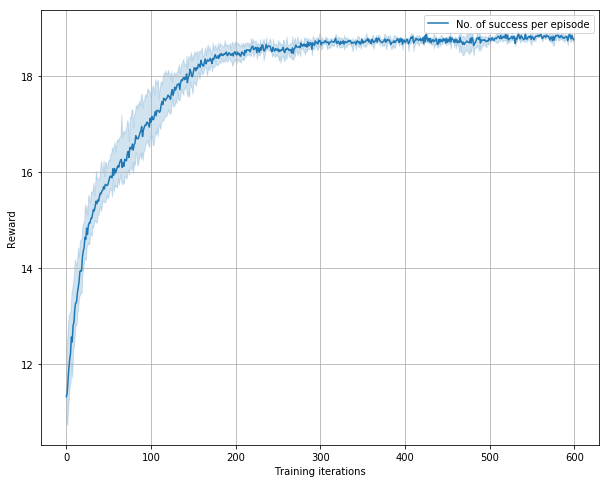

In [217]:
plot_reward(centralized_successes)

## Training with a critic

In this part we add a centralized critic network to improve policy gradient performance for decentralized problem

In [218]:
class critic_net(nn.Module):
    def __init__(self,input_dim,hidden_dim):
        super(critic_net,self).__init__()
        self.critic = nn.Sequential(nn.Linear(input_dim,hidden_dim),nn.ReLU(),nn.Linear(hidden_dim,1))
    
    def forward(self,state):
        return self.critic(state)
    
        

In [222]:
# Training function
def train_with_critic(policy_0,policy_1,critic,p0,p1,num_epochs,rollout_size,horizon,gamma,lr,
                        is_different_reward=False,with_entropy=False,entropy_coeff=0.1,seed=100,print_interval=50):
    """
    policy_0,1 - policy network of the two agents
    p0,p1 - packet arrival rates for agent0 and agent1
    num_epochs - No of training epochs
    rollout_size - No of rollouts of the MDP
    horizon - Time horizon of the MDP
    gamma - discount factor
    """
    
    print('Training begins')
    
    optimizer = torch.optim.Adam(list(policy_0.parameters())+ list(policy_1.parameters()),lr=lr)
    critic_optimizer = torch.optim.Adam(critic.parameters(),lr=lr)
    
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    rewards = []
    successes = []
    
    for i in range(num_epochs):
        #print('Starting epoch {}'.format(i))
        
        eps_success = []
        eps_reward = []
        eps_baseline = []
        
        eps_log_p0 = []
        eps_log_p1 = []
        eps_entropy_0 = []
        eps_entropy_1 = []
        total_reward = torch.zeros(rollout_size,requires_grad=False)
        total_success = torch.zeros(rollout_size,requires_grad=False)
        
        ## Generating rollouts with the current policy
        state0,state1,belief = reset(rollout_size,p0,p1)
        
        
        for t in range(horizon):
            
            # computing the prescription and actions based on current state and belief
            if with_entropy:
                prescription_0,log_p0_tilde,entropy_0 = policy_0(belief,get_entropy=True)
                prescription_1,log_p1_tilde,entropy_1 = policy_1(belief,get_entropy=True)
            else:
                prescription_0,log_p0_tilde = policy_0(belief,get_entropy=False)
                prescription_1,log_p1_tilde = policy_1(belief,get_entropy=False)
            
            # Computing the action and corresponding action log probability for each agent based on its state
            u0 = state0*prescription_0
            u1 = state1*prescription_1
            
            log_p0 = state0*log_p0_tilde
            log_p1 = state1*log_p1_tilde
            
            
            success = compute_reward(u0,u1)
            if is_different_reward:
                #reward = diverse_reward(state0,state1,u0,u1)
                reward = penalize_state_reward(state0,state1,u0,u1)
            else:
                reward = success
            
            
            
            curr_baseline = critic(torch.cat((state0.reshape(rollout_size,1).type(torch.float),state1.reshape(rollout_size,1).type(torch.float),belief),dim=1))

            
            """
            print('Time:',t)
            print('Prescription 0:', prescription_0)
            print('state0',state0)
            print('u0 ', u0)
            
            print('Prescription 1:', prescription_1)
            print('state1',state1)
            print('u1',u1)
            print('reward',reward)
            
            print('Entropy of agent 0 is {}'.format(entropy_0))
            print('Entropy of agent 1 is {}'.format(entropy_1))
            """
            
            ## Recording reward and log_prob
            eps_success.append(success)
            eps_reward.append(reward)
            eps_log_p0.append(log_p0.unsqueeze(1))
            eps_log_p1.append(log_p1.unsqueeze(1))
            eps_baseline.append(curr_baseline)
            
            if with_entropy:
                eps_entropy_0.append(entropy_0)
                eps_entropy_1.append(entropy_1)
            
            total_reward += reward
            total_success += success
            
            ## finding the next state and belief
            next_state0,next_state1 = transition(state0,state1,u0,u1,p0,p1)
            next_belief = belief_update(belief,prescription_0,prescription_1,u0,u1,p0,p1)
                    
            state0 = next_state0
            state1 = next_state1
            belief = next_belief
            
            
        
        ## compute the returns

        returns_batch = compute_episode_returns(eps_reward,rollout_size,horizon,gamma)
       
        
        ### Updating the policy
        
        eps_log_prob_0 = torch.cat((eps_log_p0[:]),dim=1)
        eps_log_prob_1 = torch.cat((eps_log_p1[:]),dim=1)
        
        baseline = torch.cat(eps_baseline,dim=1)
        
        if with_entropy: 
            eps_entropy_0 = torch.cat((eps_entropy_0[:]),dim=1)
            eps_entropy_1 = torch.cat((eps_entropy_1[:]),dim=1)
            entropy_loss = -entropy_coeff*(torch.mean(eps_entropy_0)+torch.mean(eps_entropy_1))
        
        policy_loss = -torch.mean((returns_batch-baseline.detach())*eps_log_prob_0) - torch.mean((returns_batch-baseline.detach())*eps_log_prob_1)
        
        
        
        if with_entropy:
            loss = policy_loss + entropy_loss
        else:
            loss = policy_loss
        
        optimizer.zero_grad()
        loss.backward(retain_graph=False)
        optimizer.step()
        
        
         ## Updating the critic
        critic_loss = torch.mean((returns_batch-baseline)**2)
        critic_optimizer.zero_grad()
        critic_loss.backward()
        critic_optimizer.step()
        
        ## Logging the average reward for this epoch
        
        rewards.append(torch.mean(total_reward).item())
        successes.append(torch.mean(total_success).item())
        
        ## Printing the current mean reward and success
        if i % print_interval == 0:
            print('Mean reward in epoch {} is {}'.format(i,torch.mean(total_reward).item()))
            if is_different_reward:
                print('Mean success in epoch {} is {}'.format(i,torch.mean(total_success).item()))
        
        
    print('Mean reward at the end of training {}'.format(torch.mean(total_reward).item()))
    if is_different_reward:
        print('Mean success at the end of training {}'.format(torch.mean(total_success).item()))
    
    #clear_output()
    return successes



In [223]:
n_seeds = 3
successes_critic = []

for i in range(n_seeds):
    print('Iteration no {}'.format(i))
    policy_0,policy_1 = instantiate_policy()
    critic = critic_net(input_dim=4,hidden_dim=16)
    s = train_with_critic(policy_0,policy_1,critic,p0=0.7,p1=0.6,num_epochs=600,rollout_size=300,horizon=20,gamma=1,
                             lr=5e-3,is_different_reward=False,with_entropy=False,entropy_coeff=0.13,seed=i,print_interval=100)
    successes_critic.append(s)
    test_policies(policy_0,policy_1)
    
print('Training Complete!')

Iteration no 0
Training begins
Mean reward in epoch 0 is 10.210000038146973
Mean reward in epoch 100 is 13.106666564941406
Mean reward in epoch 200 is 13.953332901000977
Mean reward in epoch 300 is 13.84000015258789
Mean reward in epoch 400 is 13.90999984741211
Mean reward in epoch 500 is 13.966666221618652
Mean reward at the end of training 13.966666221618652
No of times transmit is prescribed to agent 0 when belief=[1,0] is 100/100
No of times transmit is prescribed to agent 1 when belief=[1,0] is 0/100
No of times transmit is prescribed to agent 0 when belief=[0,1] is 100/100
No of times transmit is prescribed to agent 1 when belief=[0,1] is 0/100
Iteration no 1
Training begins
Mean reward in epoch 0 is 10.243332862854004
Mean reward in epoch 100 is 13.566666603088379
Mean reward in epoch 200 is 14.073333740234375
Mean reward in epoch 300 is 14.09000015258789
Mean reward in epoch 400 is 13.75333309173584
Mean reward in epoch 500 is 14.203332901000977
Mean reward at the end of traini

## Increasing the buffer size

Trying buffer size greater than 1 for each agent
The belief now will be a probability vector of size |X|^2 where |X| is the state space of each agent (buffer size)


In [180]:
# Training function
from IPython.display import clear_output

def train_large_buffer(policy_0,policy_1,p0,p1,num_epochs,rollout_size,horizon,gamma,lr,
                        is_different_reward=False,with_entropy=False,entropy_coeff=0.1,
                        seed=100,print_interval=50,buffer_size=2):
    """
    policy_0,1 - policy network of the two agents
    p0,p1 - packet arrival rates for agent0 and agent1
    num_epochs - No of training epochs
    rollout_size - No of rollouts of the MDP
    horizon - Time horizon of the MDP
    gamma - discount factor
    """
    
    print('Training begins')
    optimizer = torch.optim.Adam(list(policy_0.parameters())+ list(policy_1.parameters()),lr=lr)
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    rewards = []
    successes = []
    
    ## Generate transition prob using p0,p1
    transition_prob = torch.from_numpy(generate_transition_prob(p0,p1,buffer_size))
    transition_prob = torch.tensor(transition_prob,dtype=torch.float32)
    
    for i in range(num_epochs):
        #print('Starting epoch {}'.format(i))
        
        eps_success = []
        eps_reward = []
        eps_log_p0 = []
        eps_log_p1 = []
        eps_entropy_0 = []
        eps_entropy_1 = []
        total_reward = torch.zeros(rollout_size,requires_grad=False)
        total_success = torch.zeros(rollout_size,requires_grad=False)
        
        ## Generating rollouts with the current policy
        state0,state1,belief = reset_with_buffer(rollout_size,p0,p1,buffer_size)
        
        
        for t in range(horizon):
            
            # computing the prescription and actions based on current state and belief
            prescription_0 = torch.tensor([],dtype=torch.int64)
            prescription_1 = torch.tensor([],dtype=torch.int64)
            log_p0_tilde = torch.tensor([])
            log_p1_tilde = torch.tensor([])
            
            for j in range(buffer_size+1):
                # change to one hot encoding
                inp = torch.cat((belief,torch.tensor([j*1.0]*rollout_size).reshape(rollout_size,1)),dim=1)
                
                if with_entropy:
                    gamma_0,log_prob_0,entrop_0 = policy_0(inp,get_entropy=True)
                    gamma_1,log_prob_1,entrop_1 = policy_1(inp,get_entropy=True)
                else:
                    gamma_0,log_prob_0 = policy_0(inp,get_entropy=False)
                    gamma_1,log_prob_1 = policy_1(inp,get_entropy=False)
                    
                
                prescription_0 = torch.cat((prescription_0,gamma_0.reshape(rollout_size,1)),dim=1)
                prescription_1 = torch.cat((prescription_1,gamma_1.reshape(rollout_size,1)),dim=1)
                log_p0_tilde = torch.cat((log_p0_tilde,log_prob_0.reshape(rollout_size,1)),dim=1)
                log_p1_tilde = torch.cat((log_p1_tilde,log_prob_1.reshape(rollout_size,1)),dim=1)
                
                if with_entropy:
                    all_entrop_0 = torch.cat((all_entrop_0,entrop_0),dim=1)
                    all_entrop_1 = torch.cat((all_entrop_1,entrop_1),dim=1)
                                                
            
            

            u0 = prescription_0[torch.arange(rollout_size),state0]
            u1 = prescription_1[torch.arange(rollout_size),state1]
            
            
            log_p0 = log_p0_tilde[torch.arange(rollout_size),state0]
            log_p1 = log_p1_tilde[torch.arange(rollout_size),state0]
            
            
            if with_entropy:
                entropy_0 = all_entrop_0[:,state0]
                entropy_1 = all_entrop_1[:,state1]
            
           
            
            success = success_with_buffer(state0,state1,u0,u1)
            if is_different_reward:
                #reward = diverse_reward(state0,state1,u0,u1)
                #reward = penalize_state_reward(state0,state1,u0,u1)
                reward = my_reward(state0,state1,u0,u1)
            else:
                reward = success
            
            """
            print('Time:',t)
            print('Prescription 0:', prescription_0)
            print('state0',state0)
            print('u0 ', u0)
            
            print('Prescription 1:', prescription_1)
            print('state1',state1)
            print('u1',u1)
            print('reward',reward)
            
            print('Entropy of agent 0 is {}'.format(entropy_0))
            print('Entropy of agent 1 is {}'.format(entropy_1))
            """
            
            ## Recording reward and log_prob
            eps_success.append(success)
            eps_reward.append(reward)
            eps_log_p0.append(log_p0.unsqueeze(1))
            eps_log_p1.append(log_p1.unsqueeze(1))
            
            if with_entropy:
                eps_entropy_0.append(entropy_0)
                eps_entropy_1.append(entropy_1)
            
            total_reward += reward
            total_success += success
            
            ## finding the next state and belief
            next_state0,next_state1 = transition_with_buffer(state0,state1,u0,u1,p0,p1,buffer_size)
            next_belief = belief_update_control_sharing(belief,prescription_0,prescription_1,u0,u1,transition_prob)
                    
            state0 = next_state0
            state1 = next_state1
            belief = next_belief
            
            
        
        ## compute the returns

        returns_batch = compute_episode_returns(eps_reward,rollout_size,horizon,gamma)
       
        
        ### Updating the policy
        
        eps_log_prob_0 = torch.cat((eps_log_p0[:]),dim=1)
        eps_log_prob_1 = torch.cat((eps_log_p1[:]),dim=1)
        
        if with_entropy: 
            eps_entropy_0 = torch.cat((eps_entropy_0[:]),dim=1)
            eps_entropy_1 = torch.cat((eps_entropy_1[:]),dim=1)
            entropy_loss = -entropy_coeff*(torch.mean(eps_entropy_0)+torch.mean(eps_entropy_1))
        
        policy_loss = -torch.mean(returns_batch*eps_log_prob_0) - torch.mean(returns_batch*eps_log_prob_1)
        
        
        if with_entropy:
            loss = policy_loss + entropy_loss
        else:
            loss = policy_loss
        
        optimizer.zero_grad()
        loss.backward(retain_graph=False)
        optimizer.step()
            
        ## Logging the average reward for this epoch
        
        rewards.append(torch.mean(total_reward).item())
        successes.append(torch.mean(total_success).item())
        
        ## Printing the current mean reward and success
        if i % print_interval == 0:
            print('Mean reward in epoch {} is {}'.format(i,torch.mean(total_reward).item()))
            if is_different_reward:
                print('Mean success in epoch {} is {}'.format(i,torch.mean(total_success).item()))
        
        
    print('Mean reward at the end of training {}'.format(torch.mean(total_reward).item()))
    if is_different_reward:
        print('Mean success at the end of training {}'.format(torch.mean(total_success).item()))
    
    #clear_output()
    return successes


Training begins


/Users/mukul/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Mean reward in epoch 0 is 9.083333015441895
Mean reward in epoch 100 is 10.273333549499512
Mean reward in epoch 200 is 10.956666946411133
Mean reward in epoch 300 is 11.376667022705078
Mean reward in epoch 400 is 11.920000076293945
Mean reward in epoch 500 is 12.233333587646484
Mean reward at the end of training 12.970000267028809


/Users/mukul/anaconda/lib/python3.6/site-packages/matplotlib/pyplot.py:3356: MatplotlibDeprecationWarning: The 'hold' keyword argument is deprecated since 2.0.
  mplDeprecation)


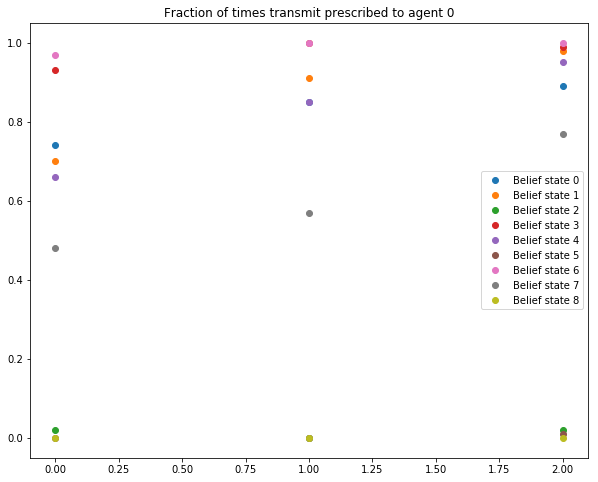

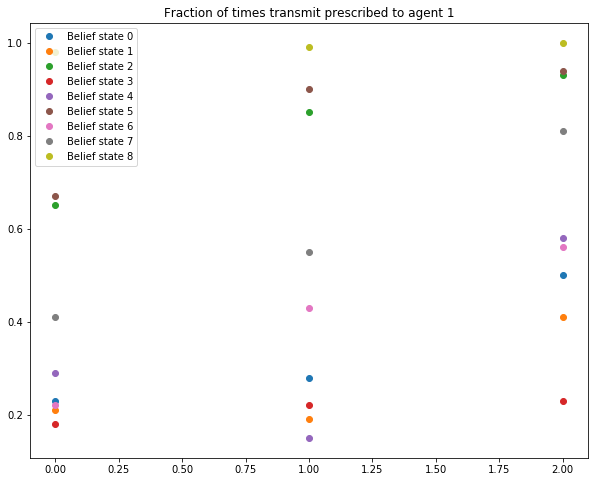

Training begins
Mean reward in epoch 0 is 9.366666793823242
Mean reward in epoch 100 is 12.776666641235352
Mean reward in epoch 200 is 13.569999694824219
Mean reward in epoch 300 is 14.020000457763672
Mean reward in epoch 400 is 13.710000038146973
Mean reward in epoch 500 is 14.226666450500488
Mean reward at the end of training 14.09000015258789


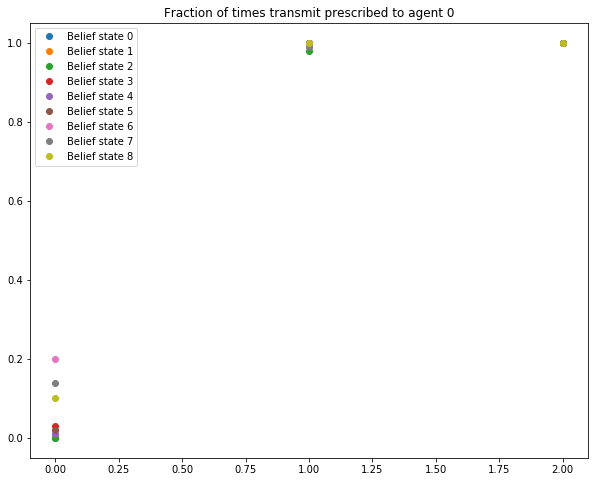

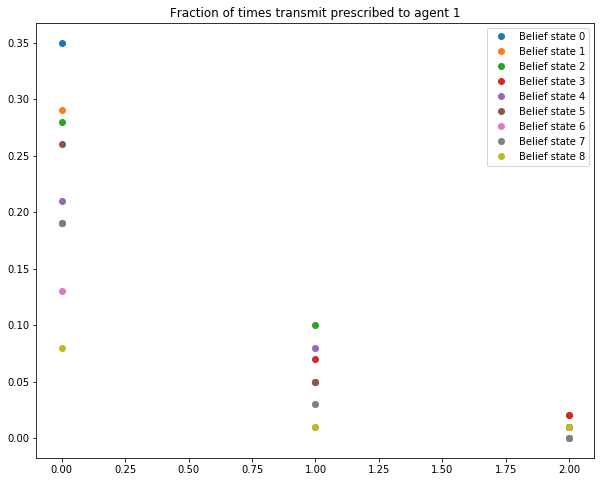

Training begins
Mean reward in epoch 0 is 8.930000305175781
Mean reward in epoch 100 is 10.136666297912598
Mean reward in epoch 200 is 10.046667098999023
Mean reward in epoch 300 is 9.926666259765625
Mean reward in epoch 400 is 10.34333324432373
Mean reward in epoch 500 is 10.823333740234375
Mean reward at the end of training 12.170000076293945


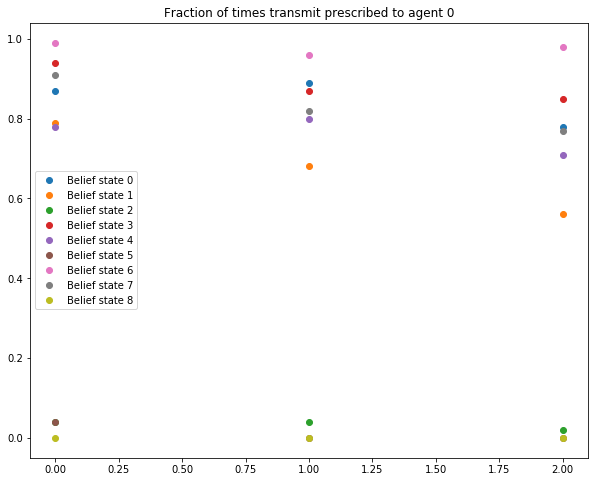

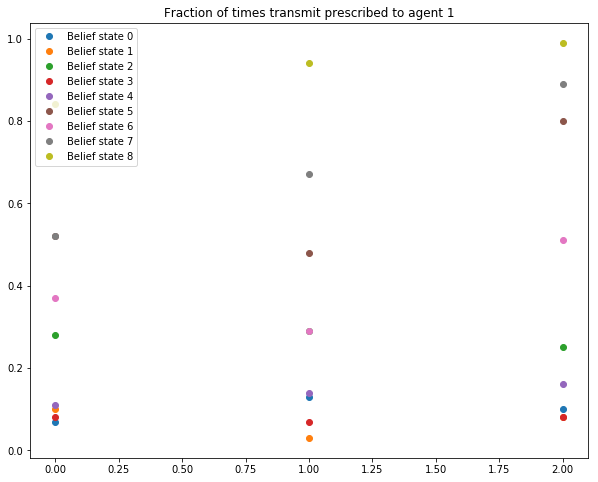

Training Complete!


In [184]:
n_seeds = 3
successes = []
buffer_size = 2

for i in range(n_seeds):
    policy_0,policy_1 = instantiate_policy(input_dim=(buffer_size+1)**2+1)
    s = train_large_buffer(policy_0,policy_1,p0=0.7,p1=0.6,num_epochs=600,rollout_size=300,horizon=20,gamma=1,
                             lr=5e-3,is_different_reward=False,with_entropy=False,
                             entropy_coeff=0.13,seed=i,print_interval=100,buffer_size=buffer_size)
    successes.append(s)
    test_buffer_policies(policy_0,policy_1,buffer_size)
    
print('Training Complete!')

In [183]:
def test_buffer_policies(policy_0,policy_1,buffer_size,n_sim=100):
    
    state0 = torch.tensor([1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]).reshape(1,9)
    state1 = torch.tensor([0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0]).reshape(1,9)
    
    joint_state_size = (buffer_size+1)**2

    
    
    count0 = np.zeros((buffer_size+1,joint_state_size))
    count1 = np.zeros((buffer_size+1,joint_state_size))

    
    for i in range(n_sim):
        for k in range(joint_state_size):
            
            state = torch.zeros(joint_state_size).reshape(1,joint_state_size)
            state[0,k] = 1.0
            
            for j in range(buffer_size+1):
                # change to one hot encoding
                inp = torch.cat((state,torch.tensor([j*1.0]).reshape(1,1)),dim=1)
                
                u0,_ = policy_0(inp)
                u1,_ = policy_1(inp)
                
                count0[j,k] += u0.item()
                count1[j,k] += u1.item()
            
       
    plt.figure()
    for i in range(joint_state_size):
        plt.plot(count0[:,i]/n_sim,'o',hold=True,label='Belief state '+ str(i))
    
    plt.legend()
    plt.title('Fraction of times transmit prescribed to agent 0')
    
    plt.figure()
    for i in range(joint_state_size):
        plt.plot(count1[:,i]/n_sim,'o',hold=True,label='Belief state '+ str(i))
    
    plt.legend()
    plt.title('Fraction of times transmit prescribed to agent 1')
    
    plt.show()
    


    """
    print('No of times transmit is prescribed to agent 0 under belief0 when x0=0 is {}/100'.format(count0_0[0]))
    print('No of times transmit is prescribed to agent 1 when belief0 when x1=0 is {}/100'.format(count1_0[0]))
    print('No of times transmit is prescribed to agent 0 when belief1 when x0=0  is {}/100'.format(count0_1[0]))
    print('No of times transmit is prescribed to agent 1 when belief1 when x1=0 is {}/100'.format(count1_1[0]))
    """

/Users/mukul/anaconda/lib/python3.6/site-packages/matplotlib/pyplot.py:3356: MatplotlibDeprecationWarning: The 'hold' keyword argument is deprecated since 2.0.
  mplDeprecation)


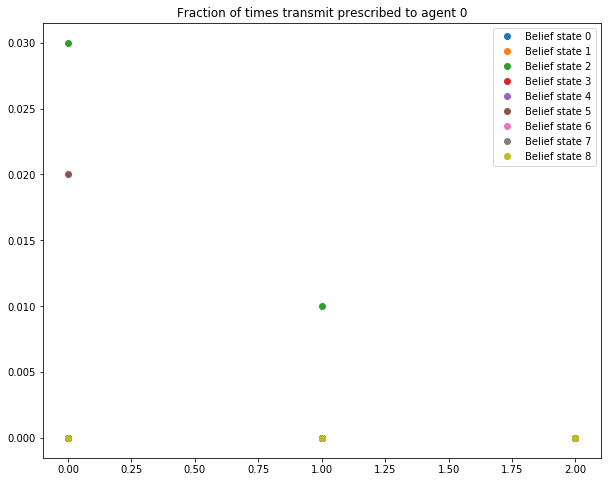

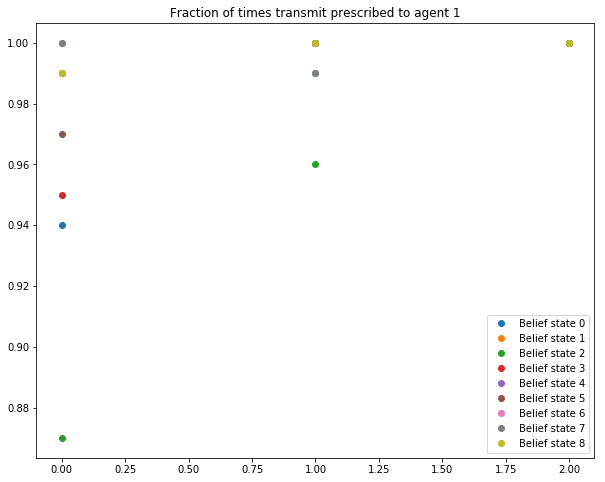

In [176]:
test_buffer_policies(policy_0,policy_1,buffer_size=2)

/Users/mukul/anaconda/lib/python3.6/site-packages/matplotlib/pyplot.py:3356: MatplotlibDeprecationWarning: The 'hold' keyword argument is deprecated since 2.0.
  mplDeprecation)


Text(0.5,1,'No of times transmit prescribed to agent 1')

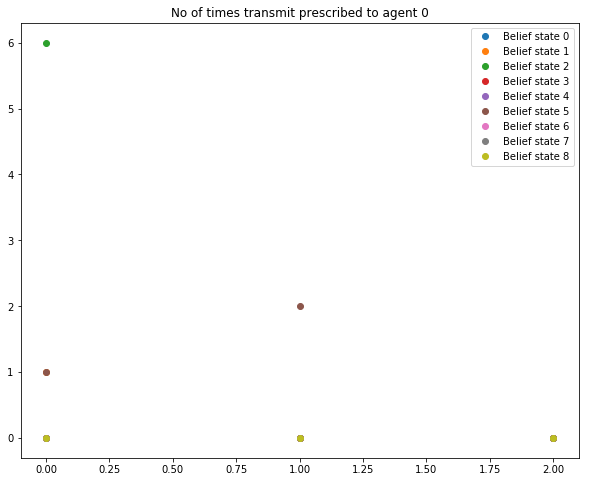

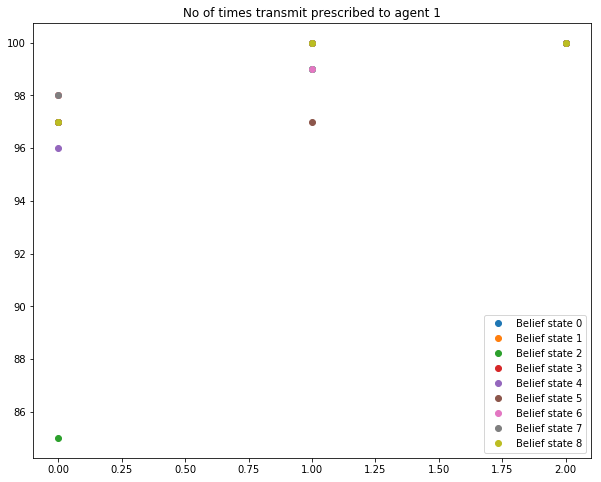

In [174]:
plt.figure()
for i in range(9):
    plt.plot(count0[:,i],'o',hold=True,label='Belief state '+str(i))
plt.legend()
plt.title('No of times transmit prescribed to agent 0')

plt.figure()
for i in range(9):
    plt.plot(count1[:,i],'o',hold=True,label='Belief state '+str(i))
plt.legend()
plt.title('No of times transmit prescribed to agent 1')